# 네이버 영화리뷰 감정분석 with CNN
참고 소스 출처(링크) : 텐서플로2와 머신러닝으로 시작하는 자연어 처리(전창욱 외, 위키북스, 2020)

# 준비
라이브러리, 파라미터 세팅

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import re
import json
import time

from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

In [2]:
# 시각화 함수
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'

TEST_SIZE = 0.2
RANDOM_SEED = 42

# tf.random.set_seed 함수를 이용해 시드를 고정하여 학습 관련 랜덤 변수에 대한 초기 상태를 유지
tf.random.set_seed(RANDOM_SEED)

# 데이터 로드

In [4]:
train_data = pd.read_csv(DATA_IN_PATH+'ratings_train.txt', sep='\t')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
# 검증 데이터 로드
dev_data = pd.read_csv(DATA_IN_PATH + 'ratings_test.txt', sep='\t')
dev_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [6]:
# 테스트(캐글) 데이터 로드
test_data = pd.read_csv(DATA_IN_PATH + 'ko_data.csv', encoding = 'cp949')
test_data.columns = ['id','document']  # 전처리 일괄 수행을 위해 컬럼명 변경(학습 데이터셋과 동일하게)
test_data.head()

,id,document
0,0,정말 많이 울었던 영화입니다.
1,1,시간 낭비예요.
2,2,포스터를 저렇게밖에 만들지 못했던 제작자의 소심함에 침을 뱉고 싶다.
3,3,지금 봐도 재미있는 영화!!! 코믹과 감동!!! 그리고 요리!!!
4,4,이걸 영화로 만드는 거야?얼마나 가는지 보자.


# 데이터 전처리
정규표현식을 활용해 한글 문자가 아닌 것들을 모두 제거한다.<br>

한글을 범위 지정할 수 있는 정규 표현식은 다음 내용을 참고한다. 일반적으로 자음의 범위는 ㄱ ~ ㅎ, 모음의 범위는 ㅏ ~ ㅣ와 같이 지정할 수 있다. 또한 완성형 한글의 범위는 가 ~ 힣과 같이 사용한다.

위의 범위 지정을 모두 반영하여 데이터셋에서 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행한다.

In [7]:
review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", train_data['document'][0]) 
print(review_text)

아 더빙 진짜 짜증나네요 목소리


특수문자가 모두 제거 되었으며, 이제 불용어를 제거하기 위해 문장을 단어로 나눠야 한다.<br>
KoNLPy 라이브러리의 okt 객체를 사용한다. 그리고 형태소 분석기를 사용할 때 어간이 추출된 단어로 나눈다.

In [8]:
okt = Okt()
review_text = okt.morphs(review_text, stem=True)
print(review_text)

['아', '더빙', '진짜', '짜증나다', '목소리']


결과를 보면 형태소 분석기를 사용해서 문장이 각 단어로 나눠져 있는 것을 확인할 수 있다.<br>
다음으로 불용어(stop words)를 제거해야 하는데, 한글 불용어가 따로 정의되어 있는 파이썬 라이브러리가 없기 때문에<br>
직접 불용어 사전을 만든 뒤 그 사전을 통해 제거해야 한다. (다음 코드는 예시)<br>
데이터에 따라 불용어를 제거하지 않고 넘어가도 괜찮을 수 있다.

In [9]:
stop_words = set(['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한'])
clean_review = [token for token in review_text if not token in stop_words]
print(clean_review)

['더빙', '진짜', '짜증나다', '목소리']


불용어까지 제거했다면 어느 정도 데이터가 정제됐다고 볼 수 있다.<br>
이제 전체 데이터에 적용하고 재사용하기 쉽게 전처리 과정을 하나의 함수로 만든다.

In [10]:
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # 함수의 인자는 다음과 같다.
    # review : 전처리 할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성한 후 인자로 받는다.
    # remove_stopwords : 불용어를 제거할지 여부 선택. 기본값은 False
    # stop_words : 불용어 사전은 사용자가 직접 입력해야 함. 기본값은 빈 리스트
    
    # 1. 한글 및 공백을 제외한 문자를 모두 제거
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    
    # 2. okt 객체를 활용해 형태소 단위로 나눈다.
    review_word = okt.morphs(review_text, stem=True)
    
    # 3. 불용어 제거(선택적 수행)
    if remove_stopwords:
        review_word = [token for token in review_word if not token in stop_words]
        
    return review_word

한글을 제외한 모든 문자 제거, 형태소 토크나이징, 불용어 제거 순으로 진행되도록 함수를 정의했다.<br>
전처리 과정을 함수로 정의했으니 학습 데이터에 대해 전처리를 진행해 본다.<br>
okt 객체를 생성하고 불용어 사전을 정의한 후 함수를 실행하면 된다.

In [11]:
stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
okt = Okt()

In [12]:
clean_train_review = []

for review in train_data['document']:
    # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_train_review.append([])  # string이 아니면 비어있는 값 추가

clean_train_review[:4]  # 맨 앞 4개 데이터 확인

[['더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']]

이제 해당 리뷰를 인덱스 벡터로 변환하면 되는데, 평가 데이터도 동일하게 진행하기 때문에 평가 데이터에 대해서도 앞 과정을 똑같이 수행한다.

In [13]:
clean_dev_review = []

for review in dev_data['document']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_dev_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_dev_review.append([])  #string이 아니면 비어있는 값 추가

clean_dev_review[:4]  # 맨 앞 4개 데이터 확인

[['굳다', 'ㅋ'],
 [],
 ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]

이제 학습 데이터와 평가 데이터에 대해 인덱스 벡터로 바꾼 후 패딩 처리만 하면 모든 전처리 과정이 끝난다.<br>
텐서플로의 전처리 모듈을 사용하는데, 토크나이징 객체를 만든 후 학습 데이터에 대해서만 적용하고<br>
해당 객체를 사용해 두 데이터를 인덱스 벡터로 만든다. 그다음 마지막으로 해당 데이터들을 패딩 처리하면 된다.

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
dev_sequences = tokenizer.texts_to_sequences(clean_dev_review)

word_vocab = tokenizer.word_index # 단어 사전 형태
word_vocab["<PAD>"] = 0

패딩 처리를 할 때 최대 길이를 8로 정한다.

In [15]:
MAX_SEQUENCE_LENGTH = 8  # 문장 최대 길이

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # 학습 데이터를 벡터화
train_labels = np.array(train_data['label']) # 학습 데이터의 라벨

dev_inputs = pad_sequences(dev_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # 검증 데이터를 벡터화
dev_labels = np.array(dev_data['label']) # 검증 데이터의 라벨

In [16]:
data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) # vocab size 추가

In [21]:
DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
DEV_INPUT_DATA = 'nsmc_dev_input.npy'
DEV_LABEL_DATA = 'nsmc_dev_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) # vocab size 추가

# 저장하는 디렉토리가 존재하지 않으면 생성
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

# 전처리 된 학습 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)
# 전처리 된 검증 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + DEV_INPUT_DATA, 'wb'), dev_inputs)
np.save(open(DATA_IN_PATH + DEV_LABEL_DATA, 'wb'), dev_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)

데이터를 전처리하면서 입력 텍스트와 데이터 라벨을 numpy.Array 형식으로 저장했기 때문에 np.load로 데이터를 불러올 수 있다.<br>
입력 텍스트 데이터는 train_input에, 데이터 라벨은 train_label에 할당한다.<br>

여기서 입력 텍스트에 대해서는 모델을 학습할 때 텍스트 길이를 맞추기 위해<br>
tensorflow.keras.preprocessing.sequence 모듈에 있는 pad_sequences 함수를 사용한다.<br>
이 함수는 최대 길이를 설정해 모든 데이터에 대한 길이를 최대 길이에 맞추는 역할을 한다.<br>
데이터 텍스트의 길이보다 길면 길이를 제한하고, 최대 길이보다 짧으면 패딩(padding) 토큰을 넣는다.<br>

데이터에 대한 사전정보를 데이터 전처리를 통해 json 파일에 저장했는데,<br>
이 사전정보는 모델에 있는 단어 임베딩 크기를 정의할 때 활용된다.<br>

이제 불러온 데이터를 모델에 적용한다.<br>
그전에 우선 학습 데이터의 일부를 검증 데이터로 분리해서 모델의 성능을 측정해야 한다.

In [16]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'data_configs.json'

train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# 모델 생성
모델에 필요한 하이퍼파라미터를 정의해본다.<br>
모델 학습 설정, 모델 레이어 차원 수 등으로 나누고, 학습을 위한 배치 크기 등은 변수로 지정한 후, 모델에 필요한 내용은 모델 	&#95;&#95;init&#95;&#95; 함수의 파라미터에 입력하기 위해 dict 객체로 정의한다.<br>
각 모델 레이어 차원 수나 드롭아웃을 정하는 하이퍼파라미터 명칭은 key에, 키에 해당하는 하이퍼파라미터 명칭에 대한 값은 value에 입력한다.

In [17]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 20  # 10
VALID_SPLIT = 0.1  # 0.1 or TEST_SIZE
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'],
         'embedding_size': 128,
         'num_filters': 100,
         'dropout_rate': 0.5,  # 0.5
         'hidden_dimension': 300,  # 250
         'output_dimension':1}

모델에 필요한 하이퍼파라미터 값으로 에폭 수, 배치 크기, 단어 사전의 크기, 임베딩 크기를 지정한다.<br>
단어 사전의 크기는 데이터 정보를 담은 딕셔너리에서 받아오고, 임베딩 크기는 128로 설정한다.

# 모델 생성

학습 데이터와 모델 하이퍼파라미터가 준비됐으니 모델을 구현해 본다.<br>
모델은 tensorflow.keras 기반으로 클래스로 모델을 정의해서 구현한다.<br>
본 케이스는 합성곱 신경망 모델을 사용한다.

In [18]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

클래스로 모델을 구현하려면 tf.keras.Model을 상속받아야 한다.<br>
tf.keras.Model을 상속받기 위해 'class CNNClassifier(tf.keras.Model):'으로 구현을 시작한다.<br>
가장 먼저 구현할 함수는 &#95;&#95;init&#95;&#95; 함수이다. 이 함수는 CNNClassifier 모델 객체를 생성할 때마다 실행된다.<br>
&#95;&#95;init&#95;&#95; 함수는 매개변수로 모델 레이어의 입력 및 출력 차원 수를 정의하는 하이퍼파라미터 정보를 dict 객체로 받는다.<br>

&#95;&#95;init&#95;&#95; 함수 구현을 시작하면 먼저 super 함수를 확인할 수 있다.<br>
tf.keras.Model 클래스를 상속받는 경우 super 함수를 통해 부모 클래스에 있는 &#95;&#95;init&#95;&#95; 함수를 호출해야 한다.<br>
super 함수를 통해 부모 클래스 &#95;&#95;init&#95;&#95; 함수 인자에 모델 이름을 전달하면<br>
tf.keras.Model을 상속받은 모든 자식은 해당 모델의 이름을 공통적으로 사용한다.<br>

그다음으로 텍스트 워드 임베딩 벡터를 위해 layers.Embedding 객체를 생성한다.<br>
이때 입력 파라미터로 데이터 사전 수와 단어 임베딩 차원 수를 입력한다.<br>

본 CNN 레이어는 Yoon Kim의 CNN과 유사하게 구현되어 있다. ("Convolutional Neural Network for Sentence Classification" 논문)<br>
임베딩 벡터를 생성한 후, 케라스의 Conv1D를 활용해 총 3개의 합성곱 레이어를 사용하고 각각 필터의 크기를 다르게 해서 값을 추출한다.<br>
self.conv_list로 관련 함수를 저장하며 kernel_size의 입력에 리스트 컴프리헨션 형태로 구현하면<br>
kernel_size가 3,4,5인 Conv1D 객체 리스트로 구현된다.<br>
합성곱 신경망 이후에 맥스 풀링 레이어를 적용한다. 즉, 해당 모델은 총 3개의 합성곱 + 맥스 풀링 레이어를 사용하는 구조이다.<br>

마지막에는 과적합을 방지하기 위한 Dropout과 완전 연결 계층인 2개 층을 쌓아<br>
최종 출력 차원인 kargs['output_dimension']출력을 맞춰 모델을 구성한다.<br>

Dropout은 tf.keras.layers.Dropout을 활용해 생성한다.<br>
이 때 파라미터 값은 Dropout을 적용할 비율값이다.

완전 연결 계층은 tf.keras.layers.Dense를 통해 객체를 생성해 구성한다.<br>
객체를 생성할 때 입력 파라미터로 네트워크를 출력할 때 나오는 벡터 차원 수 units와 네트워크에서 사용할 활성화 함수를 지정한다.<br>
활성화 함수로 relu 함수를 사용하고, tf.keras.activations.relu 함수를 activation 파라미터에 입력하면 된다.<br>

이제 피드 포워드 네트워크를 거쳐 나온 벡터를 가지고 회귀(regression)를 할 수 있도록 만들어야 한다.<br>
앞서 사용한 Dense가 위의 네트워크를 거쳐 나온 벡터에서 회귀하게 할 수 있다.<br>
앞선 방식처럼 Dense 객체를 생성하고 units에는 1을 입력하고 activation에는 tf.keras.activations.sigmoid를 지정한다.<br>
이렇게 구현하면 Dense 레이어를 통해 예측한 값을 0~1의 값으로 표현할 수 있게 된다.<br>

 &#95;&#95;init&#95;&#95; 함수를 통해 생성한 레이어들을 call 함수를 통해 실행할 수 있다.<br>
 여기서 이전에 구성한 리스트 컴프리헨션 형태의 Conv1D 리스트 값을 각각 다른 필터의 값이 Conv1D를 통해<br>
 문장의 각기 다른 표현값들을 추출해서 concat을 통해 출력값들을 합친다.<br>
 이후 완전 연결 계층(fc)을 통해 분류 모델을 만들기 위한 학습 모델 구조를 완성한다.<br>
 즉 &#95;&#95;init&#95;&#95;을 통해 생성한 레이어들을 call 함수를 통해 실행할 수 있고,<br>
 최종적으로 모든 레이어를 통과한 후에 마지막에 예측 값을 출력하는 구조다.

In [19]:
# 재현율, 정밀도, F1-Score 성능 측정 함수
from keras import backend as K

# 재현율
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# 정밀도
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# F1-Score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# # compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# # fit the model
# history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

# # evaluate the model
# loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)

# 모델 학습

RNN이 단어의 입력 순서를 중요하게 반영한다면,<br>
CNN은 문장의 지역 정보를 보존하면서 각 문장 성분의 등장 정보를 학습에 반영하는 구조로 풀어간다.<br>
학습할 때 각 필터 크기를 조절하면서 언어의 특징 값을 추출하게 되는데,<br>
기존의 N-gram(2그램,3그램) 방식과 유사하다고 볼 수 있다.<br>

예를 들어 "나는 배가 고프다"라는 문장을 2그램을 사용한다면 "나 는 / 는 배 / 배 가 / 가 고프 / 고프 다/"로<br>
각각 문장 성분을 쪼개서 활용하는 접근법, 단어의 각 벡터 값을 투영해서 컨볼루션 필터값에 적용하는 원리다.

In [20]:
model = CNNClassifier(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              #metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),f1_m,precision_m, recall_m])

검증 정확도를 통한 EarlyStopping 기능과 모델 저장 방식을 지정하고,<br>
모델을 검증하기 위한 검증 데이터도 model.fit 안에 있는 validation_split로 지정한 다음 학습을 시작한다.

In [21]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights_cnn.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))


cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/cnn_classifier_kr -- Folder already exists 



In [22]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/20
264/264 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.7753 - f1_m: 0.7677 - precision_m: 0.7857 - recall_m: 0.7613
Epoch 00001: val_accuracy improved from -inf to 0.82080, saving model to ./data_out/cnn_classifier_kr/weights_cnn.h5
264/264 [==============================] - 10s 39ms/step - loss: 0.4600 - accuracy: 0.7753 - f1_m: 0.7677 - precision_m: 0.7857 - recall_m: 0.7613 - val_loss: 0.3903 - val_accuracy: 0.8208 - val_f1_m: 0.8179 - val_precision_m: 0.8211 - val_recall_m: 0.8152
Epoch 2/20
263/264 [============================>.] - ETA: 0s - loss: 0.3536 - accuracy: 0.8446 - f1_m: 0.8429 - precision_m: 0.8505 - recall_m: 0.8369
Epoch 00002: val_accuracy improved from 0.82080 to 0.82867, saving model to ./data_out/cnn_classifier_kr/weights_cnn.h5
264/264 [==============================] - 7s 25ms/step - loss: 0.3537 - accuracy: 0.8445 - f1_m: 0.8429 - precision_m: 0.8503 - recall_m: 0.8370 - val_loss: 0.3809 - val_accuracy: 0.8287 - val_f1_m: 0.

학습 결과를 통해 학습 및 검증 정확도와 loss 값을 확인할 수 있다.<br>
성능 그래프를 출력한다.

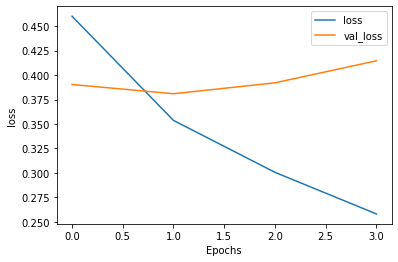

In [23]:
plot_graphs(history, 'loss')

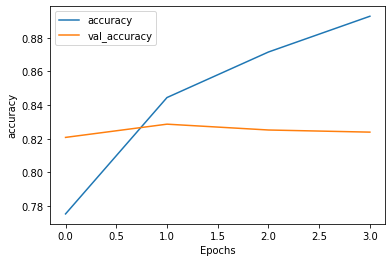

In [24]:
plot_graphs(history, 'accuracy')

이제 학습된 모델을 활용해 검증 작업을 시작한다.

# 모델 테스트 - 검증 데이터(Original 테스트 데이터셋) 성능 평가

테스트 데이터에 감정에 대한 라벨 값이 있는 경우이므로, 바로 결과를 확인할 수 있다.<br>
테스트 데이터를 불러올 때 학습 데이터를 전처리하는 과정과 동일하게 진행한 후 넘파이 파일로 저장한 데이터를 불러오면 된다.

In [25]:
DATA_OUT_PATH = './data_out/'
INPUT_DEV_DATA = 'nsmc_dev_input.npy'
LABEL_DEV_DATA = 'nsmc_dev_label.npy'
SAVE_FILE_NM = 'weights_cnn.h5' #저장된 best model 이름

dev_input = np.load(open(DATA_IN_PATH + INPUT_DEV_DATA, 'rb'))
dev_input = pad_sequences(dev_input, maxlen=dev_input.shape[1])
dev_label_data = np.load(open(DATA_IN_PATH + LABEL_DEV_DATA, 'rb'))

In [26]:
# model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))
# model.evaluate(dev_input, dev_label_data)

# # 1563/1563 [==============================] - 2s 1ms/step - loss: 0.3836 - accuracy: 0.8281
# # [0.3835543692111969, 0.8281199932098389]

In [27]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(dev_input, dev_label_data)

1563/1563 [==============================] - 3s 2ms/step - loss: 0.3835 - accuracy: 0.8255 - f1_m: 0.8206 - precision_m: 0.8329 - recall_m: 0.8179


# (참고) 제출 파일 생성

In [28]:
clean_test_review = []

for review in test_data['document']:
    # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_test_review.append([])  # string이 아니면 비어있는 값 추가

clean_test_review[:4]  # 맨 앞 4개 데이터 확인

[['정말', '많이', '울다', '영화', '이다'],
 ['시간', '낭비', '예요'],
 ['포스터',
  '를',
  '저렇게',
  '밖에',
  '만들다',
  '못',
  '하다',
  '제작자',
  '소심하다',
  '침',
  '을',
  '뱉다',
  '싶다'],
 ['지금', '보다', '재미있다', '영화', '코믹', '과', '감동', '그리고', '요리']]

In [29]:
len(clean_test_review)

11187

In [30]:
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

In [31]:
test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # 테스트 데이터를 벡터화

In [32]:
preds = model.predict(test_inputs)
preds

array([[0.95514745],
       [0.01706873],
       [0.21193871],
       ...,
       [0.5741882 ],
       [0.9774954 ],
       [0.13288136]], dtype=float32)

In [33]:
start = time.time()  # 시작 시간 저장

test_preds = []
for i, pred in enumerate(preds):
    result = 1 if pred > 0.5 else 0
    test_preds.append(result)
    print(str(i)+"번 인덱스 데이터 처리 완료 =>", pred, test_preds[i])

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

0번 인덱스 데이터 처리 완료 => [0.95514745] 1
1번 인덱스 데이터 처리 완료 => [0.01706873] 0
2번 인덱스 데이터 처리 완료 => [0.21193871] 0
3번 인덱스 데이터 처리 완료 => [0.978732] 1
4번 인덱스 데이터 처리 완료 => [0.12662883] 0
5번 인덱스 데이터 처리 완료 => [0.8376021] 1
6번 인덱스 데이터 처리 완료 => [0.0896236] 0
7번 인덱스 데이터 처리 완료 => [0.3316054] 0
8번 인덱스 데이터 처리 완료 => [0.0451766] 0
9번 인덱스 데이터 처리 완료 => [0.8933906] 1
10번 인덱스 데이터 처리 완료 => [0.975127] 1
11번 인덱스 데이터 처리 완료 => [0.1061889] 0
12번 인덱스 데이터 처리 완료 => [0.09914049] 0
13번 인덱스 데이터 처리 완료 => [0.17755699] 0
14번 인덱스 데이터 처리 완료 => [0.04627007] 0
15번 인덱스 데이터 처리 완료 => [0.9444291] 1
16번 인덱스 데이터 처리 완료 => [0.42335704] 0
17번 인덱스 데이터 처리 완료 => [0.63824886] 1
18번 인덱스 데이터 처리 완료 => [0.9205462] 1
19번 인덱스 데이터 처리 완료 => [0.98003983] 1
20번 인덱스 데이터 처리 완료 => [0.8836748] 1
21번 인덱스 데이터 처리 완료 => [0.9254086] 1
22번 인덱스 데이터 처리 완료 => [0.9620813] 1
23번 인덱스 데이터 처리 완료 => [0.9082743] 1
24번 인덱스 데이터 처리 완료 => [0.17601548] 0
25번 인덱스 데이터 처리 완료 => [0.06737546] 0
26번 인덱스 데이터 처리 완료 => [0.25841945] 0
27번 인덱스 데이터 처리 완료 => [0.26411843] 0
28번 인덱스 데이터 처리 완료 

688번 인덱스 데이터 처리 완료 => [0.28107926] 0
689번 인덱스 데이터 처리 완료 => [0.7954439] 1
690번 인덱스 데이터 처리 완료 => [0.5560172] 1
691번 인덱스 데이터 처리 완료 => [0.8134043] 1
692번 인덱스 데이터 처리 완료 => [0.4313689] 0
693번 인덱스 데이터 처리 완료 => [0.9743969] 1
694번 인덱스 데이터 처리 완료 => [0.620449] 1
695번 인덱스 데이터 처리 완료 => [0.22123283] 0
696번 인덱스 데이터 처리 완료 => [0.2501574] 0
697번 인덱스 데이터 처리 완료 => [0.9207842] 1
698번 인덱스 데이터 처리 완료 => [0.5131647] 1
699번 인덱스 데이터 처리 완료 => [0.06297933] 0
700번 인덱스 데이터 처리 완료 => [0.52035964] 1
701번 인덱스 데이터 처리 완료 => [0.9535998] 1
702번 인덱스 데이터 처리 완료 => [0.00220911] 0
703번 인덱스 데이터 처리 완료 => [0.12780814] 0
704번 인덱스 데이터 처리 완료 => [0.73482394] 1
705번 인덱스 데이터 처리 완료 => [0.578484] 1
706번 인덱스 데이터 처리 완료 => [0.77734023] 1
707번 인덱스 데이터 처리 완료 => [0.0365927] 0
708번 인덱스 데이터 처리 완료 => [0.07502504] 0
709번 인덱스 데이터 처리 완료 => [0.639737] 1
710번 인덱스 데이터 처리 완료 => [0.24695358] 0
711번 인덱스 데이터 처리 완료 => [0.8669183] 1
712번 인덱스 데이터 처리 완료 => [0.45318997] 0
713번 인덱스 데이터 처리 완료 => [0.8643437] 1
714번 인덱스 데이터 처리 완료 => [0.08972467] 0
715번 인덱스 데이터 처리 완료 

1393번 인덱스 데이터 처리 완료 => [0.10829792] 0
1394번 인덱스 데이터 처리 완료 => [0.5713815] 1
1395번 인덱스 데이터 처리 완료 => [0.70994776] 1
1396번 인덱스 데이터 처리 완료 => [0.16642871] 0
1397번 인덱스 데이터 처리 완료 => [0.14160128] 0
1398번 인덱스 데이터 처리 완료 => [0.5247362] 1
1399번 인덱스 데이터 처리 완료 => [0.98553735] 1
1400번 인덱스 데이터 처리 완료 => [0.6330847] 1
1401번 인덱스 데이터 처리 완료 => [0.13912994] 0
1402번 인덱스 데이터 처리 완료 => [0.9670401] 1
1403번 인덱스 데이터 처리 완료 => [0.9452811] 1
1404번 인덱스 데이터 처리 완료 => [0.36381954] 0
1405번 인덱스 데이터 처리 완료 => [0.04592195] 0
1406번 인덱스 데이터 처리 완료 => [0.99055636] 1
1407번 인덱스 데이터 처리 완료 => [0.12998475] 0
1408번 인덱스 데이터 처리 완료 => [0.9907183] 1
1409번 인덱스 데이터 처리 완료 => [0.6332652] 1
1410번 인덱스 데이터 처리 완료 => [0.0256296] 0
1411번 인덱스 데이터 처리 완료 => [0.4787464] 0
1412번 인덱스 데이터 처리 완료 => [0.9513664] 1
1413번 인덱스 데이터 처리 완료 => [0.23102957] 0
1414번 인덱스 데이터 처리 완료 => [0.22847496] 0
1415번 인덱스 데이터 처리 완료 => [0.03127022] 0
1416번 인덱스 데이터 처리 완료 => [0.13987552] 0
1417번 인덱스 데이터 처리 완료 => [0.9843443] 1
1418번 인덱스 데이터 처리 완료 => [0.31872705] 0
1419번 인덱스 데이터 처리 완료 => 

2100번 인덱스 데이터 처리 완료 => [0.3346818] 0
2101번 인덱스 데이터 처리 완료 => [0.01741437] 0
2102번 인덱스 데이터 처리 완료 => [0.05153516] 0
2103번 인덱스 데이터 처리 완료 => [0.70749915] 1
2104번 인덱스 데이터 처리 완료 => [0.14259572] 0
2105번 인덱스 데이터 처리 완료 => [0.35782656] 0
2106번 인덱스 데이터 처리 완료 => [0.81704575] 1
2107번 인덱스 데이터 처리 완료 => [0.90683734] 1
2108번 인덱스 데이터 처리 완료 => [0.9717398] 1
2109번 인덱스 데이터 처리 완료 => [0.12536569] 0
2110번 인덱스 데이터 처리 완료 => [0.98622966] 1
2111번 인덱스 데이터 처리 완료 => [0.48416075] 0
2112번 인덱스 데이터 처리 완료 => [0.25706416] 0
2113번 인덱스 데이터 처리 완료 => [0.9163096] 1
2114번 인덱스 데이터 처리 완료 => [0.27316374] 0
2115번 인덱스 데이터 처리 완료 => [0.9810986] 1
2116번 인덱스 데이터 처리 완료 => [0.8290986] 1
2117번 인덱스 데이터 처리 완료 => [0.4820639] 0
2118번 인덱스 데이터 처리 완료 => [0.97987384] 1
2119번 인덱스 데이터 처리 완료 => [0.1083535] 0
2120번 인덱스 데이터 처리 완료 => [0.4294405] 0
2121번 인덱스 데이터 처리 완료 => [0.98596317] 1
2122번 인덱스 데이터 처리 완료 => [0.22941548] 0
2123번 인덱스 데이터 처리 완료 => [0.3104529] 0
2124번 인덱스 데이터 처리 완료 => [0.69883126] 1
2125번 인덱스 데이터 처리 완료 => [0.96888775] 1
2126번 인덱스 데이터 처리 완료 =

2816번 인덱스 데이터 처리 완료 => [0.08016733] 0
2817번 인덱스 데이터 처리 완료 => [0.9751576] 1
2818번 인덱스 데이터 처리 완료 => [0.4787464] 0
2819번 인덱스 데이터 처리 완료 => [0.46447253] 0
2820번 인덱스 데이터 처리 완료 => [0.97628546] 1
2821번 인덱스 데이터 처리 완료 => [0.9634396] 1
2822번 인덱스 데이터 처리 완료 => [0.44185093] 0
2823번 인덱스 데이터 처리 완료 => [0.2694428] 0
2824번 인덱스 데이터 처리 완료 => [0.96171904] 1
2825번 인덱스 데이터 처리 완료 => [0.06753112] 0
2826번 인덱스 데이터 처리 완료 => [0.89561874] 1
2827번 인덱스 데이터 처리 완료 => [0.08221913] 0
2828번 인덱스 데이터 처리 완료 => [0.5895074] 1
2829번 인덱스 데이터 처리 완료 => [0.953795] 1
2830번 인덱스 데이터 처리 완료 => [0.256649] 0
2831번 인덱스 데이터 처리 완료 => [0.20749874] 0
2832번 인덱스 데이터 처리 완료 => [0.716033] 1
2833번 인덱스 데이터 처리 완료 => [0.9203825] 1
2834번 인덱스 데이터 처리 완료 => [0.7775518] 1
2835번 인덱스 데이터 처리 완료 => [0.18285534] 0
2836번 인덱스 데이터 처리 완료 => [0.00707569] 0
2837번 인덱스 데이터 처리 완료 => [0.98179734] 1
2838번 인덱스 데이터 처리 완료 => [0.9014351] 1
2839번 인덱스 데이터 처리 완료 => [0.83929545] 1
2840번 인덱스 데이터 처리 완료 => [0.33313394] 0
2841번 인덱스 데이터 처리 완료 => [0.13557293] 0
2842번 인덱스 데이터 처리 완료 => [0.

3522번 인덱스 데이터 처리 완료 => [0.22549649] 0
3523번 인덱스 데이터 처리 완료 => [0.24851306] 0
3524번 인덱스 데이터 처리 완료 => [0.72854346] 1
3525번 인덱스 데이터 처리 완료 => [0.67676514] 1
3526번 인덱스 데이터 처리 완료 => [0.18855233] 0
3527번 인덱스 데이터 처리 완료 => [0.50762725] 1
3528번 인덱스 데이터 처리 완료 => [0.53489614] 1
3529번 인덱스 데이터 처리 완료 => [0.81971467] 1
3530번 인덱스 데이터 처리 완료 => [0.94757646] 1
3531번 인덱스 데이터 처리 완료 => [0.08638591] 0
3532번 인덱스 데이터 처리 완료 => [0.03496489] 0
3533번 인덱스 데이터 처리 완료 => [0.9338514] 1
3534번 인덱스 데이터 처리 완료 => [0.00975555] 0
3535번 인덱스 데이터 처리 완료 => [0.9701985] 1
3536번 인덱스 데이터 처리 완료 => [0.70256215] 1
3537번 인덱스 데이터 처리 완료 => [0.21633452] 0
3538번 인덱스 데이터 처리 완료 => [0.06713293] 0
3539번 인덱스 데이터 처리 완료 => [0.05704386] 0
3540번 인덱스 데이터 처리 완료 => [0.17103876] 0
3541번 인덱스 데이터 처리 완료 => [0.9296218] 1
3542번 인덱스 데이터 처리 완료 => [0.6959714] 1
3543번 인덱스 데이터 처리 완료 => [0.9743969] 1
3544번 인덱스 데이터 처리 완료 => [0.5083105] 1
3545번 인덱스 데이터 처리 완료 => [0.7119106] 1
3546번 인덱스 데이터 처리 완료 => [0.96358556] 1
3547번 인덱스 데이터 처리 완료 => [0.9584854] 1
3548번 인덱스 데이터 처리 완료 

4210번 인덱스 데이터 처리 완료 => [0.99731004] 1
4211번 인덱스 데이터 처리 완료 => [0.03371502] 0
4212번 인덱스 데이터 처리 완료 => [0.88802975] 1
4213번 인덱스 데이터 처리 완료 => [0.5630319] 1
4214번 인덱스 데이터 처리 완료 => [0.0446058] 0
4215번 인덱스 데이터 처리 완료 => [0.6996587] 1
4216번 인덱스 데이터 처리 완료 => [0.89226043] 1
4217번 인덱스 데이터 처리 완료 => [0.00302666] 0
4218번 인덱스 데이터 처리 완료 => [0.06374851] 0
4219번 인덱스 데이터 처리 완료 => [0.48104572] 0
4220번 인덱스 데이터 처리 완료 => [0.810834] 1
4221번 인덱스 데이터 처리 완료 => [0.43617833] 0
4222번 인덱스 데이터 처리 완료 => [0.4787464] 0
4223번 인덱스 데이터 처리 완료 => [0.01644479] 0
4224번 인덱스 데이터 처리 완료 => [0.6079203] 1
4225번 인덱스 데이터 처리 완료 => [0.9715664] 1
4226번 인덱스 데이터 처리 완료 => [0.06649789] 0
4227번 인덱스 데이터 처리 완료 => [0.93001014] 1
4228번 인덱스 데이터 처리 완료 => [0.21701846] 0
4229번 인덱스 데이터 처리 완료 => [0.85606295] 1
4230번 인덱스 데이터 처리 완료 => [0.1247596] 0
4231번 인덱스 데이터 처리 완료 => [0.60167414] 1
4232번 인덱스 데이터 처리 완료 => [0.9795172] 1
4233번 인덱스 데이터 처리 완료 => [0.8976658] 1
4234번 인덱스 데이터 처리 완료 => [0.7751809] 1
4235번 인덱스 데이터 처리 완료 => [0.64212507] 1
4236번 인덱스 데이터 처리 완료 => [

4883번 인덱스 데이터 처리 완료 => [0.11935324] 0
4884번 인덱스 데이터 처리 완료 => [0.85196584] 1
4885번 인덱스 데이터 처리 완료 => [0.9356867] 1
4886번 인덱스 데이터 처리 완료 => [0.79974836] 1
4887번 인덱스 데이터 처리 완료 => [0.8782873] 1
4888번 인덱스 데이터 처리 완료 => [0.57159567] 1
4889번 인덱스 데이터 처리 완료 => [0.1230786] 0
4890번 인덱스 데이터 처리 완료 => [0.03643626] 0
4891번 인덱스 데이터 처리 완료 => [0.89444625] 1
4892번 인덱스 데이터 처리 완료 => [0.03052052] 0
4893번 인덱스 데이터 처리 완료 => [0.33398297] 0
4894번 인덱스 데이터 처리 완료 => [0.65868795] 1
4895번 인덱스 데이터 처리 완료 => [0.20411628] 0
4896번 인덱스 데이터 처리 완료 => [0.9225915] 1
4897번 인덱스 데이터 처리 완료 => [0.00846908] 0
4898번 인덱스 데이터 처리 완료 => [0.6697552] 1
4899번 인덱스 데이터 처리 완료 => [0.09362698] 0
4900번 인덱스 데이터 처리 완료 => [0.7017787] 1
4901번 인덱스 데이터 처리 완료 => [0.27135143] 0
4902번 인덱스 데이터 처리 완료 => [0.04952294] 0
4903번 인덱스 데이터 처리 완료 => [0.01679442] 0
4904번 인덱스 데이터 처리 완료 => [0.9765005] 1
4905번 인덱스 데이터 처리 완료 => [0.7077898] 1
4906번 인덱스 데이터 처리 완료 => [0.961449] 1
4907번 인덱스 데이터 처리 완료 => [0.03550363] 0
4908번 인덱스 데이터 처리 완료 => [0.9917133] 1
4909번 인덱스 데이터 처리 완료 => 

5545번 인덱스 데이터 처리 완료 => [0.7295222] 1
5546번 인덱스 데이터 처리 완료 => [0.95149046] 1
5547번 인덱스 데이터 처리 완료 => [0.8621141] 1
5548번 인덱스 데이터 처리 완료 => [0.9481567] 1
5549번 인덱스 데이터 처리 완료 => [0.01973338] 0
5550번 인덱스 데이터 처리 완료 => [0.7181108] 1
5551번 인덱스 데이터 처리 완료 => [0.9748496] 1
5552번 인덱스 데이터 처리 완료 => [0.05014138] 0
5553번 인덱스 데이터 처리 완료 => [0.6255052] 1
5554번 인덱스 데이터 처리 완료 => [0.8890035] 1
5555번 인덱스 데이터 처리 완료 => [0.9772734] 1
5556번 인덱스 데이터 처리 완료 => [0.9870839] 1
5557번 인덱스 데이터 처리 완료 => [0.961449] 1
5558번 인덱스 데이터 처리 완료 => [0.5593758] 1
5559번 인덱스 데이터 처리 완료 => [0.28158954] 0
5560번 인덱스 데이터 처리 완료 => [0.9769109] 1
5561번 인덱스 데이터 처리 완료 => [0.6203177] 1
5562번 인덱스 데이터 처리 완료 => [0.9862364] 1
5563번 인덱스 데이터 처리 완료 => [0.7771368] 1
5564번 인덱스 데이터 처리 완료 => [0.7215004] 1
5565번 인덱스 데이터 처리 완료 => [0.9873116] 1
5566번 인덱스 데이터 처리 완료 => [0.1943157] 0
5567번 인덱스 데이터 처리 완료 => [0.9601331] 1
5568번 인덱스 데이터 처리 완료 => [0.13536815] 0
5569번 인덱스 데이터 처리 완료 => [0.7513418] 1
5570번 인덱스 데이터 처리 완료 => [0.8579317] 1
5571번 인덱스 데이터 처리 완료 => [0.96050954

6218번 인덱스 데이터 처리 완료 => [0.8584831] 1
6219번 인덱스 데이터 처리 완료 => [0.95569366] 1
6220번 인덱스 데이터 처리 완료 => [0.56474817] 1
6221번 인덱스 데이터 처리 완료 => [0.82021123] 1
6222번 인덱스 데이터 처리 완료 => [0.21889094] 0
6223번 인덱스 데이터 처리 완료 => [0.12264978] 0
6224번 인덱스 데이터 처리 완료 => [0.98753184] 1
6225번 인덱스 데이터 처리 완료 => [0.02506341] 0
6226번 인덱스 데이터 처리 완료 => [0.12053619] 0
6227번 인덱스 데이터 처리 완료 => [0.47680804] 0
6228번 인덱스 데이터 처리 완료 => [0.99598217] 1
6229번 인덱스 데이터 처리 완료 => [0.20826706] 0
6230번 인덱스 데이터 처리 완료 => [0.04740976] 0
6231번 인덱스 데이터 처리 완료 => [0.80760866] 1
6232번 인덱스 데이터 처리 완료 => [0.02147666] 0
6233번 인덱스 데이터 처리 완료 => [0.6082966] 1
6234번 인덱스 데이터 처리 완료 => [0.93464154] 1
6235번 인덱스 데이터 처리 완료 => [0.13022682] 0
6236번 인덱스 데이터 처리 완료 => [0.904004] 1
6237번 인덱스 데이터 처리 완료 => [0.09376641] 0
6238번 인덱스 데이터 처리 완료 => [0.9410188] 1
6239번 인덱스 데이터 처리 완료 => [0.9187239] 1
6240번 인덱스 데이터 처리 완료 => [0.9628661] 1
6241번 인덱스 데이터 처리 완료 => [0.20391327] 0
6242번 인덱스 데이터 처리 완료 => [0.20299959] 0
6243번 인덱스 데이터 처리 완료 => [0.913203] 1
6244번 인덱스 데이터 처리 완료 =

6899번 인덱스 데이터 처리 완료 => [0.08998582] 0
6900번 인덱스 데이터 처리 완료 => [0.09588601] 0
6901번 인덱스 데이터 처리 완료 => [0.7611848] 1
6902번 인덱스 데이터 처리 완료 => [0.8649235] 1
6903번 인덱스 데이터 처리 완료 => [0.925733] 1
6904번 인덱스 데이터 처리 완료 => [0.48906025] 0
6905번 인덱스 데이터 처리 완료 => [0.01516984] 0
6906번 인덱스 데이터 처리 완료 => [0.02377615] 0
6907번 인덱스 데이터 처리 완료 => [0.97691447] 1
6908번 인덱스 데이터 처리 완료 => [0.05952664] 0
6909번 인덱스 데이터 처리 완료 => [0.9890988] 1
6910번 인덱스 데이터 처리 완료 => [0.37478143] 0
6911번 인덱스 데이터 처리 완료 => [0.31418723] 0
6912번 인덱스 데이터 처리 완료 => [0.992853] 1
6913번 인덱스 데이터 처리 완료 => [0.03848963] 0
6914번 인덱스 데이터 처리 완료 => [0.47881833] 0
6915번 인덱스 데이터 처리 완료 => [0.7369456] 1
6916번 인덱스 데이터 처리 완료 => [0.5508622] 1
6917번 인덱스 데이터 처리 완료 => [0.25300625] 0
6918번 인덱스 데이터 처리 완료 => [0.8731829] 1
6919번 인덱스 데이터 처리 완료 => [0.49869817] 0
6920번 인덱스 데이터 처리 완료 => [0.07371782] 0
6921번 인덱스 데이터 처리 완료 => [0.9113212] 1
6922번 인덱스 데이터 처리 완료 => [0.69844] 1
6923번 인덱스 데이터 처리 완료 => [0.45091897] 0
6924번 인덱스 데이터 처리 완료 => [0.9587653] 1
6925번 인덱스 데이터 처리 완료 => [0.6

7526번 인덱스 데이터 처리 완료 => [0.8127792] 1
7527번 인덱스 데이터 처리 완료 => [0.06330059] 0
7528번 인덱스 데이터 처리 완료 => [0.03045556] 0
7529번 인덱스 데이터 처리 완료 => [0.9432693] 1
7530번 인덱스 데이터 처리 완료 => [0.02879554] 0
7531번 인덱스 데이터 처리 완료 => [0.02203252] 0
7532번 인덱스 데이터 처리 완료 => [0.19031103] 0
7533번 인덱스 데이터 처리 완료 => [0.01781317] 0
7534번 인덱스 데이터 처리 완료 => [0.94038683] 1
7535번 인덱스 데이터 처리 완료 => [0.5546179] 1
7536번 인덱스 데이터 처리 완료 => [0.9856839] 1
7537번 인덱스 데이터 처리 완료 => [0.9844381] 1
7538번 인덱스 데이터 처리 완료 => [0.99387485] 1
7539번 인덱스 데이터 처리 완료 => [0.9083567] 1
7540번 인덱스 데이터 처리 완료 => [0.18383236] 0
7541번 인덱스 데이터 처리 완료 => [0.21138412] 0
7542번 인덱스 데이터 처리 완료 => [0.96485525] 1
7543번 인덱스 데이터 처리 완료 => [0.9558676] 1
7544번 인덱스 데이터 처리 완료 => [0.67131656] 1
7545번 인덱스 데이터 처리 완료 => [0.1684339] 0
7546번 인덱스 데이터 처리 완료 => [0.06721573] 0
7547번 인덱스 데이터 처리 완료 => [0.4787464] 0
7548번 인덱스 데이터 처리 완료 => [0.98824954] 1
7549번 인덱스 데이터 처리 완료 => [0.98921144] 1
7550번 인덱스 데이터 처리 완료 => [0.07885689] 0
7551번 인덱스 데이터 처리 완료 => [0.9025369] 1
7552번 인덱스 데이터 처리 완료 =>

8164번 인덱스 데이터 처리 완료 => [0.94908226] 1
8165번 인덱스 데이터 처리 완료 => [0.4263132] 0
8166번 인덱스 데이터 처리 완료 => [0.4747217] 0
8167번 인덱스 데이터 처리 완료 => [0.9590455] 1
8168번 인덱스 데이터 처리 완료 => [0.12762192] 0
8169번 인덱스 데이터 처리 완료 => [0.5083578] 1
8170번 인덱스 데이터 처리 완료 => [0.92036533] 1
8171번 인덱스 데이터 처리 완료 => [0.99029106] 1
8172번 인덱스 데이터 처리 완료 => [0.18510202] 0
8173번 인덱스 데이터 처리 완료 => [0.5145616] 1
8174번 인덱스 데이터 처리 완료 => [0.7953426] 1
8175번 인덱스 데이터 처리 완료 => [0.8740848] 1
8176번 인덱스 데이터 처리 완료 => [0.1221345] 0
8177번 인덱스 데이터 처리 완료 => [0.5171681] 1
8178번 인덱스 데이터 처리 완료 => [0.8778931] 1
8179번 인덱스 데이터 처리 완료 => [0.60854316] 1
8180번 인덱스 데이터 처리 완료 => [0.9730963] 1
8181번 인덱스 데이터 처리 완료 => [0.12668638] 0
8182번 인덱스 데이터 처리 완료 => [0.949417] 1
8183번 인덱스 데이터 처리 완료 => [0.09532613] 0
8184번 인덱스 데이터 처리 완료 => [0.93003607] 1
8185번 인덱스 데이터 처리 완료 => [0.892132] 1
8186번 인덱스 데이터 처리 완료 => [0.93939716] 1
8187번 인덱스 데이터 처리 완료 => [0.16732734] 0
8188번 인덱스 데이터 처리 완료 => [0.28307045] 0
8189번 인덱스 데이터 처리 완료 => [0.986161] 1
8190번 인덱스 데이터 처리 완료 => [0.080

8792번 인덱스 데이터 처리 완료 => [0.9447235] 1
8793번 인덱스 데이터 처리 완료 => [0.7618008] 1
8794번 인덱스 데이터 처리 완료 => [0.07736488] 0
8795번 인덱스 데이터 처리 완료 => [0.968171] 1
8796번 인덱스 데이터 처리 완료 => [0.96468574] 1
8797번 인덱스 데이터 처리 완료 => [0.28728947] 0
8798번 인덱스 데이터 처리 완료 => [0.15190688] 0
8799번 인덱스 데이터 처리 완료 => [0.05348269] 0
8800번 인덱스 데이터 처리 완료 => [0.6974231] 1
8801번 인덱스 데이터 처리 완료 => [0.09041404] 0
8802번 인덱스 데이터 처리 완료 => [0.32693228] 0
8803번 인덱스 데이터 처리 완료 => [0.2846936] 0
8804번 인덱스 데이터 처리 완료 => [0.47975686] 0
8805번 인덱스 데이터 처리 완료 => [0.9714138] 1
8806번 인덱스 데이터 처리 완료 => [0.76492137] 1
8807번 인덱스 데이터 처리 완료 => [0.02551465] 0
8808번 인덱스 데이터 처리 완료 => [0.872933] 1
8809번 인덱스 데이터 처리 완료 => [0.89367545] 1
8810번 인덱스 데이터 처리 완료 => [0.7757302] 1
8811번 인덱스 데이터 처리 완료 => [0.29553849] 0
8812번 인덱스 데이터 처리 완료 => [0.90283096] 1
8813번 인덱스 데이터 처리 완료 => [0.1740493] 0
8814번 인덱스 데이터 처리 완료 => [0.04315441] 0
8815번 인덱스 데이터 처리 완료 => [0.25149998] 0
8816번 인덱스 데이터 처리 완료 => [0.98516256] 1
8817번 인덱스 데이터 처리 완료 => [0.9897831] 1
8818번 인덱스 데이터 처리 완료 => [

9410번 인덱스 데이터 처리 완료 => [0.12455201] 0
9411번 인덱스 데이터 처리 완료 => [0.09801938] 0
9412번 인덱스 데이터 처리 완료 => [0.08882593] 0
9413번 인덱스 데이터 처리 완료 => [0.10337189] 0
9414번 인덱스 데이터 처리 완료 => [0.07243638] 0
9415번 인덱스 데이터 처리 완료 => [0.7365103] 1
9416번 인덱스 데이터 처리 완료 => [0.98567086] 1
9417번 인덱스 데이터 처리 완료 => [0.06618391] 0
9418번 인덱스 데이터 처리 완료 => [0.6821318] 1
9419번 인덱스 데이터 처리 완료 => [0.47977594] 0
9420번 인덱스 데이터 처리 완료 => [0.02127166] 0
9421번 인덱스 데이터 처리 완료 => [0.7804803] 1
9422번 인덱스 데이터 처리 완료 => [0.9552303] 1
9423번 인덱스 데이터 처리 완료 => [0.92306113] 1
9424번 인덱스 데이터 처리 완료 => [0.34195876] 0
9425번 인덱스 데이터 처리 완료 => [0.12096987] 0
9426번 인덱스 데이터 처리 완료 => [0.00506109] 0
9427번 인덱스 데이터 처리 완료 => [0.9166857] 1
9428번 인덱스 데이터 처리 완료 => [0.9472553] 1
9429번 인덱스 데이터 처리 완료 => [0.64248055] 1
9430번 인덱스 데이터 처리 완료 => [0.03051514] 0
9431번 인덱스 데이터 처리 완료 => [0.62063336] 1
9432번 인덱스 데이터 처리 완료 => [0.9551022] 1
9433번 인덱스 데이터 처리 완료 => [0.21355888] 0
9434번 인덱스 데이터 처리 완료 => [0.8833985] 1
9435번 인덱스 데이터 처리 완료 => [0.89144105] 1
9436번 인덱스 데이터 처리 완료 

10094번 인덱스 데이터 처리 완료 => [0.17062873] 0
10095번 인덱스 데이터 처리 완료 => [0.7508005] 1
10096번 인덱스 데이터 처리 완료 => [0.84356076] 1
10097번 인덱스 데이터 처리 완료 => [0.9515126] 1
10098번 인덱스 데이터 처리 완료 => [0.93411267] 1
10099번 인덱스 데이터 처리 완료 => [0.93907285] 1
10100번 인덱스 데이터 처리 완료 => [0.91623104] 1
10101번 인덱스 데이터 처리 완료 => [0.42359763] 0
10102번 인덱스 데이터 처리 완료 => [0.99094135] 1
10103번 인덱스 데이터 처리 완료 => [0.97553307] 1
10104번 인덱스 데이터 처리 완료 => [0.8165337] 1
10105번 인덱스 데이터 처리 완료 => [0.784548] 1
10106번 인덱스 데이터 처리 완료 => [0.87088835] 1
10107번 인덱스 데이터 처리 완료 => [0.98524636] 1
10108번 인덱스 데이터 처리 완료 => [0.04888488] 0
10109번 인덱스 데이터 처리 완료 => [0.03022573] 0
10110번 인덱스 데이터 처리 완료 => [0.40972304] 0
10111번 인덱스 데이터 처리 완료 => [0.65761703] 1
10112번 인덱스 데이터 처리 완료 => [0.23198071] 0
10113번 인덱스 데이터 처리 완료 => [0.06838974] 0
10114번 인덱스 데이터 처리 완료 => [0.60857165] 1
10115번 인덱스 데이터 처리 완료 => [0.20568497] 0
10116번 인덱스 데이터 처리 완료 => [0.31755775] 0
10117번 인덱스 데이터 처리 완료 => [0.6645871] 1
10118번 인덱스 데이터 처리 완료 => [0.936947] 1
10119번 인덱스 데이터 처리 완료 => [0.111556

10776번 인덱스 데이터 처리 완료 => [0.68156004] 1
10777번 인덱스 데이터 처리 완료 => [0.92401963] 1
10778번 인덱스 데이터 처리 완료 => [0.9582379] 1
10779번 인덱스 데이터 처리 완료 => [0.98242086] 1
10780번 인덱스 데이터 처리 완료 => [0.20398062] 0
10781번 인덱스 데이터 처리 완료 => [0.52668023] 1
10782번 인덱스 데이터 처리 완료 => [0.10570373] 0
10783번 인덱스 데이터 처리 완료 => [0.8740267] 1
10784번 인덱스 데이터 처리 완료 => [0.28131777] 0
10785번 인덱스 데이터 처리 완료 => [0.19280088] 0
10786번 인덱스 데이터 처리 완료 => [0.9761861] 1
10787번 인덱스 데이터 처리 완료 => [0.10217572] 0
10788번 인덱스 데이터 처리 완료 => [0.34713733] 0
10789번 인덱스 데이터 처리 완료 => [0.6398524] 1
10790번 인덱스 데이터 처리 완료 => [0.5913566] 1
10791번 인덱스 데이터 처리 완료 => [0.16973951] 0
10792번 인덱스 데이터 처리 완료 => [0.45356345] 0
10793번 인덱스 데이터 처리 완료 => [0.97466326] 1
10794번 인덱스 데이터 처리 완료 => [0.47522408] 0
10795번 인덱스 데이터 처리 완료 => [0.8277578] 1
10796번 인덱스 데이터 처리 완료 => [0.24729528] 0
10797번 인덱스 데이터 처리 완료 => [0.98352367] 1
10798번 인덱스 데이터 처리 완료 => [0.97292554] 1
10799번 인덱스 데이터 처리 완료 => [0.06072063] 0
10800번 인덱스 데이터 처리 완료 => [0.13089511] 0
10801번 인덱스 데이터 처리 완료 => [0.8732

In [34]:
# 테스트 데이터의 리뷰 부분을 리스트 처리
test_id = list(test_data['id'])

# 판다스 데이터프레임 통해 데이터 구성하여 output에 투입
output = pd.DataFrame( data={"Id": test_id, "Predicted": test_preds} )
output.head()

,Id,Predicted
0,0,1
1,1,0
2,2,0
3,3,1
4,4,0


In [35]:
# 해당 경로가 없으면 생성
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

# csv파일로 만든다
output.to_csv(DATA_OUT_PATH + "NSMC_CNN.csv", index = False)  # 앙상블 조합 및 캐글 제출 용도

### 캐글 제출 결과
**[2020.12.20]**<br>
0.81548

---